# Determine how to remove spatial trend (mainly SIF)

Notes
- Best model changes depending on the season
- EVI explains most of the variability in SIF alone during summer months
  - relationship is generally linear but less so in winter months
  - after removing EVI, there is basically no relationship between coordinates and the SIF - EVI residuals
- SIF is quadratic with latitude and has some relationship with longitude
- Latitude and to a lesser extent longitude are good covariates for XCO2 in the summer but less so in the winter

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, "../src")

In [3]:
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.formula.api as smf

from seaborn import pairplot

import fields
import plot
from stat_tools import standardize

In [4]:
%matplotlib inline

## Setup the data

In [5]:
# Get data: 4x5-degree monthly average, cont. US
ds = xr.open_dataset("../data/exp_pro/OCO2_MODIS_4x5deg_monthly_conus_augmented.nc")

# Format as multi-fields
ds_xco2 = ds[["xco2", "xco2_var"]]
ds_sif = ds[["sif", "sif_var", "evi"]]

In [6]:
# Analysis variables
# NOTE: year must be >= 2015 to use EVI (notice timedelta)
month = 3
timedelta = -2
fast_dist = True

timestamps = np.array(ds.time[ds.time.dt.month == month].values, dtype="datetime64[D]")
timestamp = timestamps[0]
timestamp

numpy.datetime64('2015-03-01')

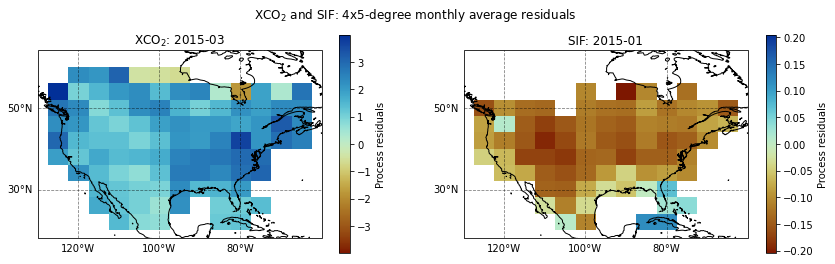

In [7]:
# NOTE: make sure that spatial trend isn't already removed in preprocessing!
mf = fields.MultiField(ds_xco2, ds_sif, timestamp, timedelta=timedelta, fast_dist=fast_dist, covars_2="evi")
plot.plot_fields(mf)

## Fit different surface models for SIF

In [8]:
# format data for statsmodels
f = mf.field_2
df = pd.DataFrame({
    "lat": f.coords[:, 0],
    "lon": f.coords[:, 1],
    "evi": f.covariates,
    "values": f.values
})
df[["lat", "lon", "evi"]] = df[["lat", "lon", "evi"]].apply(lambda x: standardize(x), axis=0)
df

lat       lon       evi    values
130    0.762763 -1.911563  2.068907 -0.091177
138    1.220351 -1.911563  0.554668 -0.159846
193   -0.152413 -1.880343  2.245097 -0.024301
201    0.305175 -1.880343  2.101825 -0.088164
209    0.762763 -1.880343  2.044818 -0.084045
...         ...       ...       ...       ...
10013  1.220351  1.990977 -0.458575 -0.106977
10084  0.762763  2.022197  0.710738 -0.071374
10092  1.220351  2.022197 -0.495967 -0.106977
10163  0.762763  2.053417  0.671024 -0.081210
10171  1.220351  2.053417 -0.545266 -0.106977

[1306 rows x 4 columns]

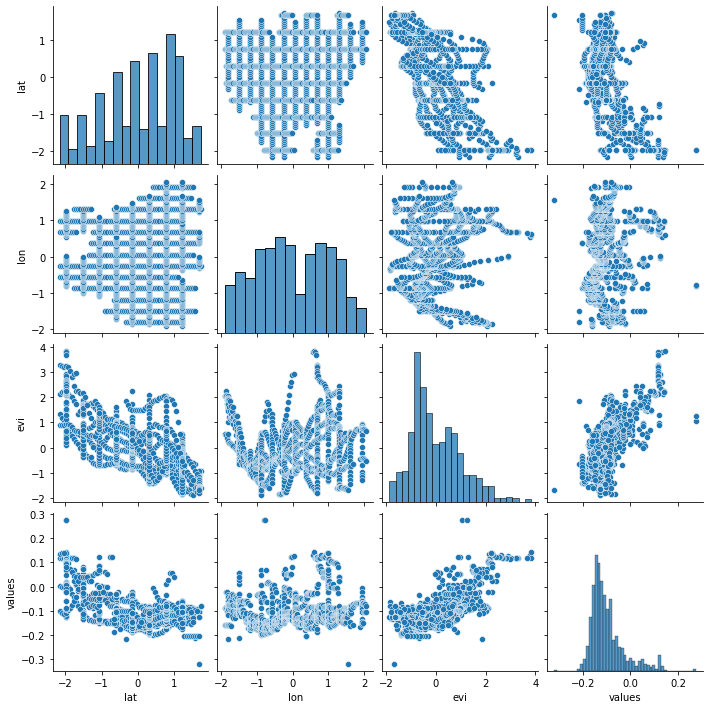

In [9]:
pairplot(df)

In [10]:
res_base = smf.ols(formula='values ~ lat + lon', data=df).fit()
res_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     340.1
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          1.42e-119
Time:                        16:23:23   Log-Likelihood:                 1898.9
No. Observations:                1306   AIC:                            -3792.
Df Residuals:                    1303   BIC:                            -3776.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0993      0.002    -63.424      0.000      -0.102      -0.096
lat           -0.0392      0.002    -24.974      0.000      -0.042      -0.036
lon            0.0131      0.002      8.376      0.000       0.010       0.016
==============================================================================
Omnibus:                      130.070   Durbin-Watson:                   0.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.443
Skew:                           0.726   Prob(JB):                     1.34e-43
Kurtosis:                       4.232   Cond. No.                         1.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
res = smf.ols(formula='values ~ evi', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     1546.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          1.21e-223
Time:                        16:23:23   Log-Likelihood:                 2135.2
No. Observations:                1306   AIC:                            -4266.
Df Residuals:                    1304   BIC:                            -4256.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0993      0.001    -76.030      0.000      -0.102      -0.097
evi            0.0514      0.001     39.318      0.000       0.049       0.054
==============================================================================
Omnibus:                      216.408   Durbin-Watson:                   0.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              730.935
Skew:                           0.798   Prob(JB):                    1.90e-159
Kurtosis:                       6.299   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
res = smf.ols(formula='values ~ lon * lat', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     282.4
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          3.51e-141
Time:                        16:23:23   Log-Likelihood:                 1951.9
No. Observations:                1306   AIC:                            -3896.
Df Residuals:                    1302   BIC:                            -3875.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0987      0.002    -65.560      0.000      -0.102      -0.096
lon            0.0179      0.002     11.362      0.000       0.015       0.021
lat           -0.0369      0.002    -24.215      0.000      -0.040      -0.034
lon:lat       -0.0181      0.002    -10.494      0.000      -0.021      -0.015
==============================================================================
Omnibus:                      166.040   Durbin-Watson:                   0.774
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              326.396
Skew:                           0.780   Prob(JB):                     1.33e-71
Kurtosis:                       4.888   Cond. No.                         1.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
res = smf.ols(formula='values ~ np.power(lat, 2) * np.power(lon, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     241.1
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          2.10e-124
Time:                        16:23:24   Log-Likelihood:                 1913.1
No. Observations:                1306   AIC:                            -3818.
Df Residuals:                    1302   BIC:                            -3798.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.1545      0.003    -50.674      0.000      -0.160      -0.148
np.power(lat, 2)                      0.0455      0.002     22.532      0.000       0.042       0.049
np.power(lon, 2)                      0.0182      0.002      8.276      0.000       0.014       0.022
np.power(lat, 2):np.power(lon, 2)    -0.0100      0.002     -5.198      0.000      -0.014      -0.006
==============================================================================
Omnibus:                      146.530   Durbin-Watson:                   0.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              354.739
Skew:                           0.634   Prob(JB):                     9.32e-78
Kurtosis:                       5.216   Cond. No.                         6.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
res = smf.ols(formula='values ~ np.power(lat, 3) * np.power(lon, 3)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     271.3
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          9.56e-137
Time:                        16:23:24   Log-Likelihood:                 1941.7
No. Observations:                1306   AIC:                            -3875.
Df Residuals:                    1302   BIC:                            -3855.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.1047      0.002    -68.312      0.000      -0.108      -0.102
np.power(lat, 3)                     -0.0166      0.001    -25.347      0.000      -0.018      -0.015
np.power(lon, 3)                      0.0027      0.001      3.520      0.000       0.001       0.004
np.power(lat, 3):np.power(lon, 3)    -0.0020      0.001     -3.655      0.000      -0.003      -0.001
==============================================================================
Omnibus:                       89.794   Durbin-Watson:                   0.730
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              121.409
Skew:                           0.587   Prob(JB):                     4.33e-27
Kurtosis:                       3.923   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
res = smf.ols(formula='values ~ lon * lat + np.power(lon, 2) * np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     348.9
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          1.36e-266
Time:                        16:23:24   Log-Likelihood:                 2251.4
No. Observations:                1306   AIC:                            -4489.
Df Residuals:                    1299   BIC:                            -4453.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.1500      0.002    -63.134      0.000      -0.155      -0.145
lon                                   0.0159      0.001     12.104      0.000       0.013       0.018
lat                                  -0.0310      0.001    -23.069      0.000      -0.034      -0.028
lon:lat                              -0.0189      0.001    -13.594      0.000      -0.022      -0.016
np.power(lon, 2)                      0.0244      0.002     14.024      0.000       0.021       0.028
np.power(lat, 2)                      0.0336      0.002     20.052      0.000       0.030       0.037
np.power(lon, 2):np.power(lat, 2)    -0.0078      0.002     -4.900      0.000      -0.011      -0.005
==============================================================================
Omnibus:                      194.341   Durbin-Watson:                   1.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1222.991
Skew:                           0.517   Prob(JB):                    2.70e-266
Kurtosis:                       7.627   Cond. No.                         6.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
res = smf.ols(formula='values ~ lon * lat + np.power(lon, 2) * np.power(lat, 2) + np.power(lon, 3) * np.power(lat, 3)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     259.3
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          1.90e-282
Time:                        16:23:24   Log-Likelihood:                 2297.1
No. Observations:                1306   AIC:                            -4574.
Df Residuals:                    1296   BIC:                            -4522.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.1491      0.002    -62.120      0.000      -0.154      -0.144
lon                                   0.0368      0.003     14.093      0.000       0.032       0.042
lat                                  -0.0311      0.003    -11.739      0.000      -0.036      -0.026
lon:lat                              -0.0213      0.002     -8.977      0.000      -0.026      -0.017
np.power(lon, 2)                      0.0226      0.002     12.877      0.000       0.019       0.026
np.power(lat, 2)                      0.0328      0.002     17.453      0.000       0.029       0.036
np.power(lon, 2):np.power(lat, 2)    -0.0063      0.002     -3.939      0.000      -0.009      -0.003
np.power(lon, 3)                     -0.0117      0.001     -9.226      0.000      -0.014      -0.009
np.power(lat, 3)                     -0.0008      0.001     -0.630      0.529      -0.003       0.002
np.power(lon, 3):np.power(lat, 3)     0.0031      0.001      4.419      0.000       0.002       0.004
==============================================================================
Omnibus:                      199.122   Durbin-Watson:                   1.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1647.166
Skew:                           0.436   Prob(JB):                         0.00
Kurtosis:                       8.432   Cond. No.                         11.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
res = smf.ols(formula='values ~ lon * lat + np.power(lon, 2) + np.power(lat, 2) + np.power(lon, 3) + np.power(lat, 3)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     321.6
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          3.29e-278
Time:                        16:23:24   Log-Likelihood:                 2281.4
No. Observations:                1306   AIC:                            -4547.
Df Residuals:                    1298   BIC:                            -4505.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1454      0.002    -68.153      0.000      -0.150      -0.141
lon                  0.0356      0.003     13.590      0.000       0.030       0.041
lat                 -0.0312      0.003    -11.726      0.000      -0.036      -0.026
lon:lat             -0.0120      0.002     -7.992      0.000      -0.015      -0.009
np.power(lon, 2)     0.0181      0.001     14.840      0.000       0.016       0.021
np.power(lat, 2)     0.0280      0.001     20.812      0.000       0.025       0.031
np.power(lon, 3)    -0.0114      0.001     -9.275      0.000      -0.014      -0.009
np.power(lat, 3)    -0.0007      0.001     -0.615      0.539      -0.003       0.002
==============================================================================
Omnibus:                      202.785   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1439.846
Skew:                           0.508   Prob(JB):                         0.00
Kurtosis:                       8.042   Cond. No.                         7.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
res = smf.ols(formula='values ~ lon + lon:lat + np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     292.1
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          5.55e-145
Time:                        16:23:24   Log-Likelihood:                 1960.7
No. Observations:                1306   AIC:                            -3913.
Df Residuals:                    1302   BIC:                            -3893.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1334      0.002    -64.893      0.000      -0.137      -0.129
lon                  0.0126      0.002      7.996      0.000       0.010       0.016
lon:lat             -0.0210      0.002    -12.339      0.000      -0.024      -0.018
np.power(lat, 2)     0.0348      0.001     24.738      0.000       0.032       0.038
==============================================================================
Omnibus:                      184.190   Durbin-Watson:                   1.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              481.306
Skew:                           0.757   Prob(JB):                    3.06e-105
Kurtosis:                       5.560   Cond. No.                         2.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
res = smf.ols(formula='values ~ lon + lon:lat + np.power(lat, 2) + lon:np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     236.0
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          1.98e-152
Time:                        16:23:24   Log-Likelihood:                 1980.9
No. Observations:                1306   AIC:                            -3952.
Df Residuals:                    1301   BIC:                            -3926.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1334      0.002    -65.881      0.000      -0.137      -0.129
lon                      0.0036      0.002      1.690      0.091      -0.001       0.008
lon:lat                 -0.0199      0.002    -11.805      0.000      -0.023      -0.017
np.power(lat, 2)         0.0333      0.001     23.727      0.000       0.031       0.036
lon:np.power(lat, 2)     0.0106      0.002      6.392      0.000       0.007       0.014
==============================================================================
Omnibus:                      242.866   Durbin-Watson:                   1.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              920.864
Skew:                           0.859   Prob(JB):                    1.09e-200
Kurtosis:                       6.738   Cond. No.                         2.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
res = smf.ols(formula='values ~ lon + lon:lat + np.power(lat, 2) + np.power(lon, 2):np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.401
Method:                 Least Squares   F-statistic:                     219.0
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          9.93e-144
Time:                        16:23:24   Log-Likelihood:                 1960.7
No. Observations:                1306   AIC:                            -3911.
Df Residuals:                    1301   BIC:                            -3886.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.1333      0.002    -63.958      0.000      -0.137      -0.129
lon                                   0.0127      0.002      7.912      0.000       0.010       0.016
lon:lat                              -0.0210      0.002    -12.337      0.000      -0.024      -0.018
np.power(lat, 2)                      0.0350      0.002     21.673      0.000       0.032       0.038
np.power(lon, 2):np.power(lat, 2)    -0.0004      0.001     -0.274      0.784      -0.003       0.002
==============================================================================
Omnibus:                      184.028   Durbin-Watson:                   1.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              478.568
Skew:                           0.758   Prob(JB):                    1.20e-104
Kurtosis:                       5.549   Cond. No.                         3.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Selected model

In [21]:
res = smf.ols(formula='values ~ lon * lat + np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     389.2
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          1.75e-220
Time:                        16:23:24   Log-Likelihood:                 2138.4
No. Observations:                1306   AIC:                            -4267.
Df Residuals:                    1301   BIC:                            -4241.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1255      0.002    -68.331      0.000      -0.129      -0.122
lon                  0.0137      0.001      9.905      0.000       0.011       0.016
lat                 -0.0280      0.001    -20.175      0.000      -0.031      -0.025
lon:lat             -0.0171      0.001    -11.448      0.000      -0.020      -0.014
np.power(lat, 2)     0.0268      0.001     20.741      0.000       0.024       0.029
==============================================================================
Omnibus:                      180.044   Durbin-Watson:                   0.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              555.603
Skew:                           0.690   Prob(JB):                    2.25e-121
Kurtosis:                       5.882   Cond. No.                         2.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
res_sif = smf.ols(formula='values ~ evi', data=df).fit()
res_sif.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     1546.
Date:                Wed, 25 Aug 2021   Prob (F-statistic):          1.21e-223
Time:                        16:23:24   Log-Likelihood:                 2135.2
No. Observations:                1306   AIC:                            -4266.
Df Residuals:                    1304   BIC:                            -4256.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0993      0.001    -76.030      0.000      -0.102      -0.097
evi            0.0514      0.001     39.318      0.000       0.049       0.054
==============================================================================
Omnibus:                      216.408   Durbin-Watson:                   0.866
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              730.935
Skew:                           0.798   Prob(JB):                    1.90e-159
Kurtosis:                       6.299   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
mf.field_2.values = mf.field_2.values - res_sif.predict()

## Fit different surface models for XCO2

In [24]:
# format data for statsmodels
f = mf.field_1
df = pd.DataFrame({
    "lat": f.coords[:, 0],
    "lon": f.coords[:, 1],
    "values": f.values
    })
df[["lat", "lon"]] = df[["lat", "lon"]].apply(lambda x: standardize(x), axis=0)
df

lat       lon    values
0     0.035590 -1.802629  3.847168
1     0.423841 -1.802629  2.947388
2     1.200344 -1.802629  2.385864
3    -0.352662 -1.772732  1.947083
4     0.035590 -1.772732  3.847168
...        ...       ...       ...
1690  0.035590  2.024278  2.972107
1691  0.423841  2.024278  2.038788
1692  0.812092  2.024278  2.636566
1693  1.200344  2.024278  2.901306
1694  1.588595  2.024278 -0.317047

[1695 rows x 3 columns]

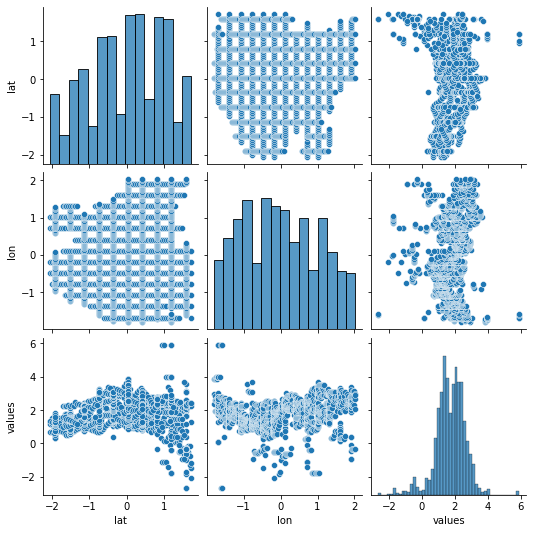

In [25]:
pairplot(df)

In [26]:
res_base = smf.ols(formula='values ~ lat + lon', data=df).fit()
res_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     18.12
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           1.64e-08
Time:                        16:23:27   Log-Likelihood:                -2229.0
No. Observations:                1695   AIC:                             4464.
Df Residuals:                    1692   BIC:                             4480.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7265      0.022     78.791      0.000       1.684       1.769
lat            0.0004      0.022      0.018      0.986      -0.043       0.043
lon            0.1319      0.022      6.019      0.000       0.089       0.175
==============================================================================
Omnibus:                      240.541   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              920.584
Skew:                          -0.652   Prob(JB):                    1.25e-200
Kurtosis:                       6.367   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
res = smf.ols(formula='values ~ lat * lon', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     34.52
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           1.18e-21
Time:                        16:23:27   Log-Likelihood:                -2196.6
No. Observations:                1695   AIC:                             4401.
Df Residuals:                    1691   BIC:                             4423.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7275      0.022     80.336      0.000       1.685       1.770
lat           -0.0071      0.022     -0.328      0.743      -0.049       0.035
lon            0.1764      0.022      7.947      0.000       0.133       0.220
lat:lon       -0.1960      0.024     -8.121      0.000      -0.243      -0.149
==============================================================================
Omnibus:                      271.712   Durbin-Watson:                   1.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              931.462
Skew:                          -0.776   Prob(JB):                    5.44e-203
Kurtosis:                       6.284   Cond. No.                         1.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
res = smf.ols(formula='values ~ np.power(lon, 2) + np.power(lat, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     212.2
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           5.99e-83
Time:                        16:23:27   Log-Likelihood:                -2057.3
No. Observations:                1695   AIC:                             4121.
Df Residuals:                    1692   BIC:                             4137.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.8846      0.036     52.190      0.000       1.814       1.955
np.power(lon, 2)     0.1781      0.020      8.850      0.000       0.139       0.218
np.power(lat, 2)    -0.3364      0.020    -17.061      0.000      -0.375      -0.298
==============================================================================
Omnibus:                      192.465   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              708.121
Skew:                          -0.519   Prob(JB):                    1.71e-154
Kurtosis:                       5.992   Cond. No.                         3.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
res = smf.ols(formula='values ~ lat + lat:lon', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     19.49
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           4.29e-09
Time:                        16:23:27   Log-Likelihood:                -2227.7
No. Observations:                1695   AIC:                             4461.
Df Residuals:                    1692   BIC:                             4478.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7273      0.022     78.888      0.000       1.684       1.770
lat           -0.0044      0.022     -0.200      0.841      -0.047       0.039
lat:lon       -0.1487      0.024     -6.243      0.000      -0.195      -0.102
==============================================================================
Omnibus:                      219.245   Durbin-Watson:                   0.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              649.152
Skew:                          -0.667   Prob(JB):                    1.09e-141
Kurtosis:                       5.722   Cond. No.                         1.10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
res = smf.ols(formula='values ~ lat', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.002394
Date:                Wed, 25 Aug 2021   Prob (F-statistic):              0.961
Time:                        16:23:27   Log-Likelihood:                -2247.0
No. Observations:                1695   AIC:                             4498.
Df Residuals:                    1693   BIC:                             4509.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7265      0.022     77.984      0.000       1.683       1.770
lat            0.0011      0.022      0.049      0.961      -0.042       0.045
==============================================================================
Omnibus:                      203.011   Durbin-Watson:                   0.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              638.882
Skew:                          -0.600   Prob(JB):                    1.86e-139
Kurtosis:                       5.758   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Selected model

In [31]:
res_xco2 = smf.ols(formula='values ~ lon + lat', data=df).fit()
res_xco2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     18.12
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           1.64e-08
Time:                        16:23:27   Log-Likelihood:                -2229.0
No. Observations:                1695   AIC:                             4464.
Df Residuals:                    1692   BIC:                             4480.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7265      0.022     78.791      0.000       1.684       1.769
lon            0.1319      0.022      6.019      0.000       0.089       0.175
lat            0.0004      0.022      0.018      0.986      -0.043       0.043
==============================================================================
Omnibus:                      240.541   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              920.584
Skew:                          -0.652   Prob(JB):                    1.25e-200
Kurtosis:                       6.367   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
mf.field_1.values = mf.field_1.values - res_xco2.predict()

## Look at the resulting fields

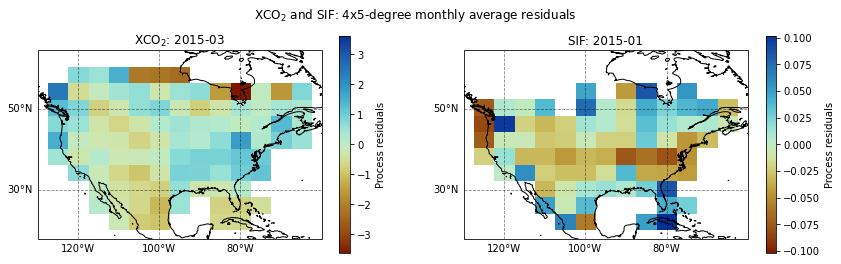

In [33]:
mf.field_1.ds = mf.field_1.to_xarray()
mf.field_2.ds = mf.field_2.to_xarray()
plot.plot_fields(mf)

## Analyze models for SIF with EVI already removed

In [34]:
# format data for statsmodels
# NOTE: assumes EVI was the best model above and has been removed
f = mf.field_2 
df = pd.DataFrame({
    "lat": f.coords[:, 0],
    "lon": f.coords[:, 1],
    "values": f.values
    })
df[["lat", "lon"]] = df[["lat", "lon"]].apply(lambda x: standardize(x), axis=0)
df

lat       lon    values
0     0.762763 -1.911563 -0.098162
1     1.220351 -1.911563 -0.089018
2    -0.152413 -1.880343 -0.040341
3     0.305175 -1.880343 -0.096841
4     0.762763 -1.880343 -0.089793
...        ...       ...       ...
1301  1.220351  1.990977  0.015921
1302  0.762763  2.022197 -0.008566
1303  1.220351  2.022197  0.017843
1304  0.762763  2.053417 -0.016360
1305  1.220351  2.053417  0.020376

[1306 rows x 3 columns]

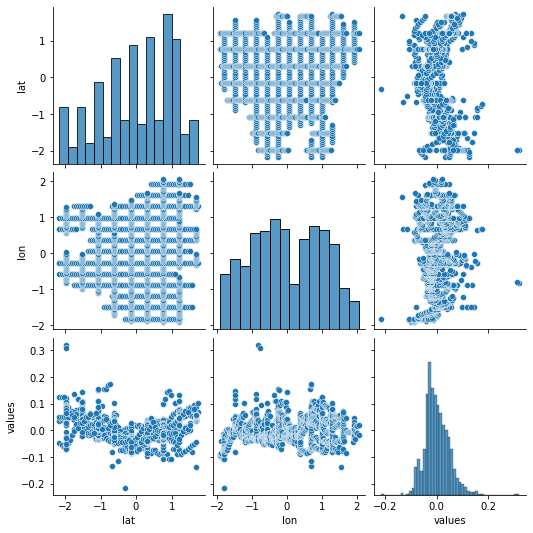

In [35]:
pairplot(df)

In [36]:
res_base = smf.ols(formula='values ~ lat + lon', data=df).fit()
res_base.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     22.31
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           2.97e-10
Time:                        16:23:30   Log-Likelihood:                 2157.1
No. Observations:                1306   AIC:                            -4308.
Df Residuals:                    1303   BIC:                            -4293.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.089e-17      0.001   -2.4e-14      1.000      -0.003       0.003
lat           -0.0051      0.001     -3.951      0.000      -0.008      -0.003
lon            0.0071      0.001      5.520      0.000       0.005       0.010
==============================================================================
Omnibus:                      206.581   Durbin-Watson:                   0.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              721.284
Skew:                           0.751   Prob(JB):                    2.37e-157
Kurtosis:                       6.316   Cond. No.                         1.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
res = smf.ols(formula='values ~ np.power(lon, 2)', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     27.68
Date:                Wed, 25 Aug 2021   Prob (F-statistic):           1.68e-07
Time:                        16:23:30   Log-Likelihood:                 2148.9
No. Observations:                1306   AIC:                            -4294.
Df Residuals:                    1304   BIC:                            -4283.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0067      0.002      3.705      0.000       0.003       0.010
np.power(lon, 2)    -0.0068      0.001     -5.261      0.000      -0.009      -0.004
==============================================================================
Omnibus:                      222.476   Durbin-Watson:                   0.883
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              702.935
Skew:                           0.841   Prob(JB):                    2.29e-153
Kurtosis:                       6.176   Cond. No.                         2.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
res = smf.ols(formula='values ~ lon:lat', data=df).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 values   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.349
Date:                Wed, 25 Aug 2021   Prob (F-statistic):              0.126
Time:                        16:23:30   Log-Likelihood:                 2136.3
No. Observations:                1306   AIC:                            -4269.
Df Residuals:                    1304   BIC:                            -4258.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -7.5e-05      0.001     -0.057      0.954      -0.003       0.002
lon:lat        0.0022      0.001      1.533      0.126      -0.001       0.005
==============================================================================
Omnibus:                      220.632   Durbin-Watson:                   0.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              721.495
Skew:                           0.823   Prob(JB):                    2.13e-157
Kurtosis:                       6.247   Cond. No.                         1.09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""